# [ Going Deeper(CV) ] 2. 없다면 어떻게 될까? (ResNet Ablation Study)

✅정의

---
### - 📖목차
* ✔️2-7. 프로젝트: ResNet Ablation Study
* ✔️회고 및 결론
* ✔️Reference(참고자료)

<br>



## ✔️2-7. 프로젝트: ResNet Ablation Study
---
### 1) ResNet 기본 블록 구성하기


In [ ]:
# 데이터 불러오기
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()

In [ ]:
BATCH_SIZE = 32  # 256
EPOCHS = 10  # 15
LR = 0.1
OPT_DECAY = 0.0001
MOMENTUM = 0.9
L2_WEIGHT_DECAY = 1e-4
BATCH_NORM_DECAY = 0.9
BATCH_NORM_EPSILON = 1e-5

ACTIVATION = 'sigmoid'
NUM_CLASSES = 1

In [ ]:
# tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteOBSPNJ/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(18610, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(4652, shape=(), dtype=int64)

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [ ]:
ds_info.features["label"].num_classes  # 2

2

In [ ]:
ds_info.features["label"].names  # ['cat', 'dog']

['cat', 'dog']

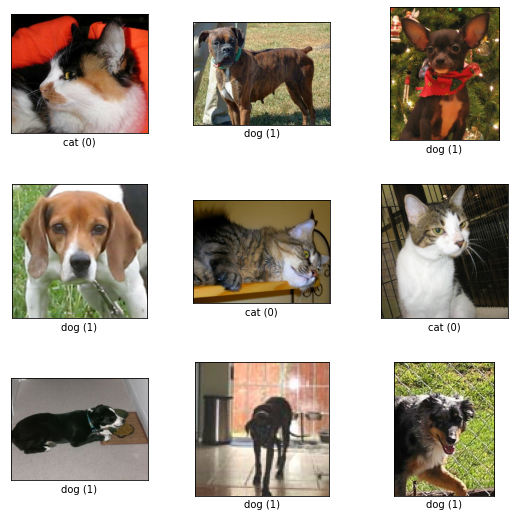

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

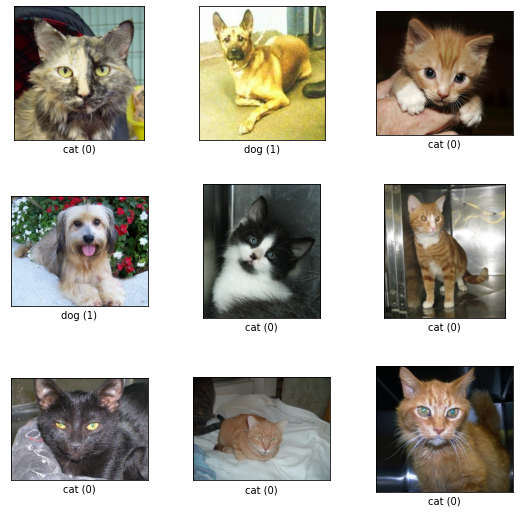

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

### 2. 딥러닝 네트워크 설계하기

-----
#### - 함수 정의

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
for input in ds_train.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(32, 224, 224, 3)
(32,)


In [ ]:
def conv_block(input_layer, 
                channel, 
                kernel_size, 
                strides=1, 
                activation='relu',
                l2_weight_decay=1e-4,
                batch_norm_decay=0.9,
                batch_norm_epsilon=1e-5):
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=kernel_size,
        kernel_initializer='he_normal',
        kernel_regularizer=keras.regularizers.l2(l2_weight_decay),
        padding='same',
        strides=strides,
        use_bias=False,
    )(input_layer)
    
    x = keras.layers.BatchNormalization(
        # momentum=batch_norm_decay,
        # epsilon=batch_norm_epsilon,
    )(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [ ]:
def build_net_block(input_layer, 
                    cnn_count=3, 
                    channel=64, 
                    block_num=0, 
                    is_50=True,
                    is_ResNet=True):

    x = input_layer
    
    # 첫 번째 conv_layer 에서 strides=2 설정해서 너비와 높이를 줄임
    # => 필터의 개수(=채널)가 증가할 때마다 너비와 높이를 줄임

    # ResNet-50, Plain-50
    if is_50:
        if is_ResNet: # ResNet-50
            for i in range(cnn_count):
                if i == 0:
                    shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-50
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
                else:
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
    # ResNet-34, Plain-34
    else:
        if is_ResNet:  # ResNet-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3))
                else:
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3))

    return x

In [ ]:
def build_net(input_shape=(32,32,3),
                cnn_count_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10, 
                is_50=True,
                is_ResNet=True,
                activation='softmax',
                name='ResNet_50'):
    
    # 모델 생성 전, config list들이 같은 길이인지 확인
    assert len(cnn_count_list) == len(channel_list)
    
    # input layer 생성
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer 설정
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서
    # - is_ResNet=True 일 경우, Residual block 블록을 생성합니다.
    # - is_ResNet=False 일 경우, Plain block 블록을 생성합니다.
    for block_num, (cnn_count, channel) in enumerate(zip(cnn_count_list, channel_list)):
        x = build_net_block(x, 
                            cnn_count=cnn_count, 
                            channel=channel, 
                            block_num=block_num, 
                            is_50=is_50,
                            is_ResNet=is_ResNet)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                        activation=activation, 
                        kernel_initializer='he_normal'
                        )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

<br>

- ResNet 34, 50모델과 일반 네트워크로 만들어서 비교하기

In [ ]:
# ResNet-34, ResNet-50 생성

resnet_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_34',
)
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

In [ ]:
resnet_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_50',
)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 112, 112, 64  256        ['conv2d_36[0][0]']              
 ormalization)                  )                                                         

In [ ]:
plain_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_34',
)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        368

In [ ]:
plain_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_50',
)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_122 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 56, 56, 64)        409

In [ ]:
def comile_and_fit(model, ds_train, ds_test, ds_info, learning_rate=0.001, momentum= 0.9, opt_decay=0.0001, batch_size=128, epochs=15):
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=learning_rate,
            momentum=momentum,
            decay=opt_decay,
            clipnorm=1.
        ),
        metrics=['accuracy'],
    )

    history = model.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['train[80%:]'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history

<br>

### 3. 딥러닝 네트워크 학습시키기

In [ ]:
history_resnet_34 = comile_and_fit(resnet_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
581/581 [==============================] - 1367s 2s/step - loss: 2.2851 - accuracy: 0.5636 - val_loss: 2.2078 - val_accuracy: 0.5288
Epoch 2/10
581/581 [==============================] - 1363s 2s/step - loss: 1.9045 - accuracy: 0.6271 - val_loss: 1.9191 - val_accuracy: 0.5511
Epoch 3/10
581/581 [==============================] - 1362s 2s/step - loss: 1.6225 - accuracy: 0.6827 - val_loss: 1.6600 - val_accuracy: 0.5855
Epoch 4/10
581/581 [==============================] - 1357s 2s/step - loss: 1.3893 - accuracy: 0.7329 - val_loss: 1.4042 - val_accuracy: 0.6442
Epoch 5/10
581/581 [==============================] - 1368s 2s/step - loss: 1.2015 - accuracy: 0.7724 - val_loss: 1.2916 - val_accuracy: 0.6300
Epoch 6/10
581/581 [==============================] - 1367s 2s/step - loss: 1.0455 - accuracy: 0.8038 - val_loss: 1.6741 - val_accuracy: 0.6167
Epoch 7/10
581/581 [==============================] - 1358s 2s/step - loss: 0.9399 - accuracy: 0.8133 - val_loss: 1.3540 - val_accuracy:

In [ ]:
history_plain_34 = comile_and_fit(plain_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
581/581 [==============================] - 75s 110ms/step - loss: 2.1226 - accuracy: 0.5181 - val_loss: 1.9626 - val_accuracy: 0.4918
Epoch 2/10
581/581 [==============================] - 64s 109ms/step - loss: 1.8234 - accuracy: 0.5489 - val_loss: 1.7146 - val_accuracy: 0.5227
Epoch 3/10
581/581 [==============================] - 64s 110ms/step - loss: 1.6079 - accuracy: 0.5577 - val_loss: 1.5359 - val_accuracy: 0.5032
Epoch 4/10
581/581 [==============================] - 64s 110ms/step - loss: 1.4310 - accuracy: 0.5914 - val_loss: 1.3729 - val_accuracy: 0.6004
Epoch 5/10
581/581 [==============================] - 64s 110ms/step - loss: 1.2920 - accuracy: 0.6112 - val_loss: 1.2223 - val_accuracy: 0.6292
Epoch 6/10
581/581 [==============================] - 64s 110ms/step - loss: 1.1746 - accuracy: 0.6329 - val_loss: 1.1528 - val_accuracy: 0.5970
Epoch 7/10
581/581 [==============================] - 64s 110ms/step - loss: 1.0833 - accuracy: 0.6429 - val_loss: 1.0536 - val_ac

In [ ]:
history_resnet_50 = comile_and_fit(resnet_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
581/581 [==============================] - 725s 1s/step - loss: 5.7865 - accuracy: 0.5319 - val_loss: 5.1181 - val_accuracy: 0.5296
Epoch 2/10
581/581 [==============================] - 707s 1s/step - loss: 4.6193 - accuracy: 0.6173 - val_loss: 4.1918 - val_accuracy: 0.6399
Epoch 3/10
581/581 [==============================] - 708s 1s/step - loss: 3.8315 - accuracy: 0.6717 - val_loss: 3.6232 - val_accuracy: 0.6054
Epoch 4/10
581/581 [==============================] - 697s 1s/step - loss: 3.2153 - accuracy: 0.7136 - val_loss: 2.9659 - val_accuracy: 0.7184
Epoch 5/10
581/581 [==============================] - 709s 1s/step - loss: 2.7292 - accuracy: 0.7403 - val_loss: 2.7432 - val_accuracy: 0.6211
Epoch 6/10
581/581 [==============================] - 708s 1s/step - loss: 2.3451 - accuracy: 0.7634 - val_loss: 2.7708 - val_accuracy: 0.5452
Epoch 7/10
581/581 [==============================] - 705s 1s/step - loss: 2.0359 - accuracy: 0.7823 - val_loss: 1.9720 - val_accuracy: 0.7552

In [ ]:
history_plain_50 = comile_and_fit(plain_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
581/581 [==============================] - 2074s 4s/step - loss: 4.8871 - accuracy: 0.5082 - val_loss: 4.4126 - val_accuracy: 0.4866
Epoch 2/10
581/581 [==============================] - 2079s 4s/step - loss: 4.0172 - accuracy: 0.5454 - val_loss: 3.6816 - val_accuracy: 0.5026
Epoch 3/10
581/581 [==============================] - 2132s 4s/step - loss: 3.3921 - accuracy: 0.5413 - val_loss: 3.1356 - val_accuracy: 0.4978
Epoch 4/10
581/581 [==============================] - 2133s 4s/step - loss: 2.9073 - accuracy: 0.5523 - val_loss: 2.7244 - val_accuracy: 0.5134
Epoch 5/10
581/581 [==============================] - 2132s 4s/step - loss: 2.5221 - accuracy: 0.5706 - val_loss: 2.3673 - val_accuracy: 0.5316
Epoch 6/10
581/581 [==============================] - 2141s 4s/step - loss: 2.2171 - accuracy: 0.5719 - val_loss: 2.1640 - val_accuracy: 0.5232
Epoch 7/10
581/581 [==============================] - 2143s 4s/step - loss: 1.9615 - accuracy: 0.6004 - val_loss: 1.9044 - val_accuracy:

### 4. 얼마나 잘 만들었는지 확인하기(테스트)

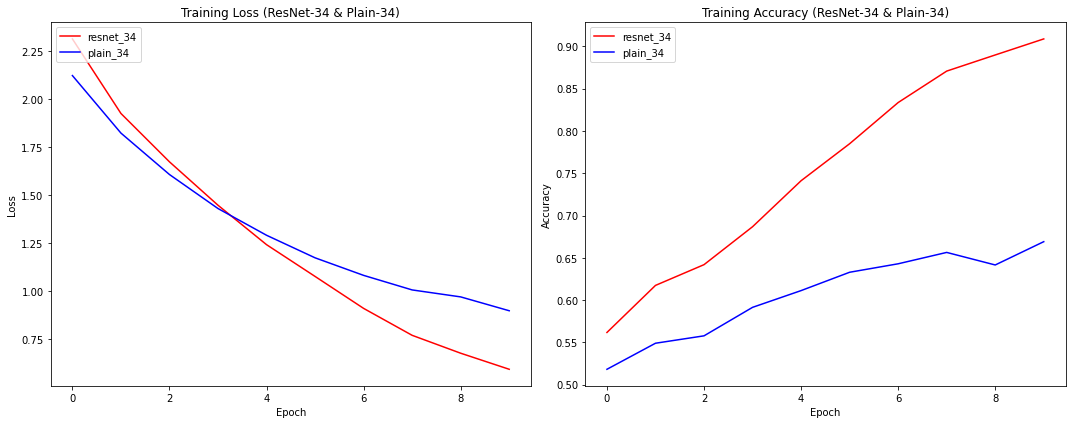

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Training Loss (ResNet-34 & Plain-34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_plain_34.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-34 & Plain-34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_34.png')

plt.show()

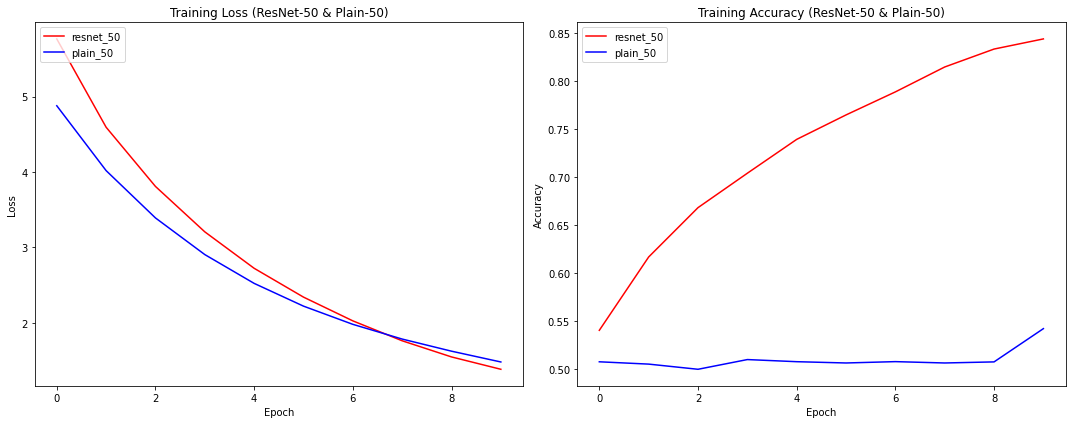

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Training Loss (ResNet-50 & Plain-50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['accuracy'], 'r')
plt.plot(history_plain_50.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-50 & Plain-50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_50.png')

plt.show()

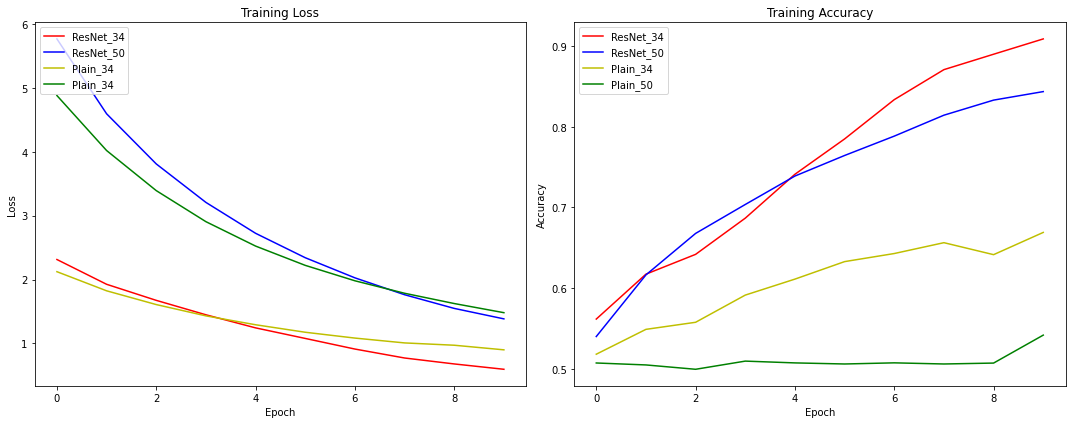

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'y')
plt.plot(history_plain_50.history['loss'], 'g')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_34'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_resnet_50.history['accuracy'], 'b')
plt.plot(history_plain_34.history['accuracy'], 'y')
plt.plot(history_plain_50.history['accuracy'], 'g')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_All.png')

plt.show()

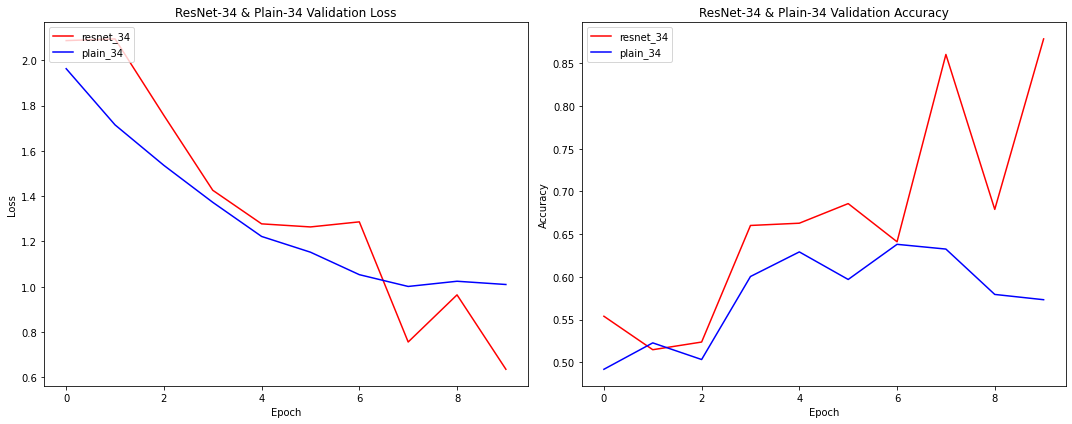

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_plain_34.history['val_loss'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_34.png')

plt.show()

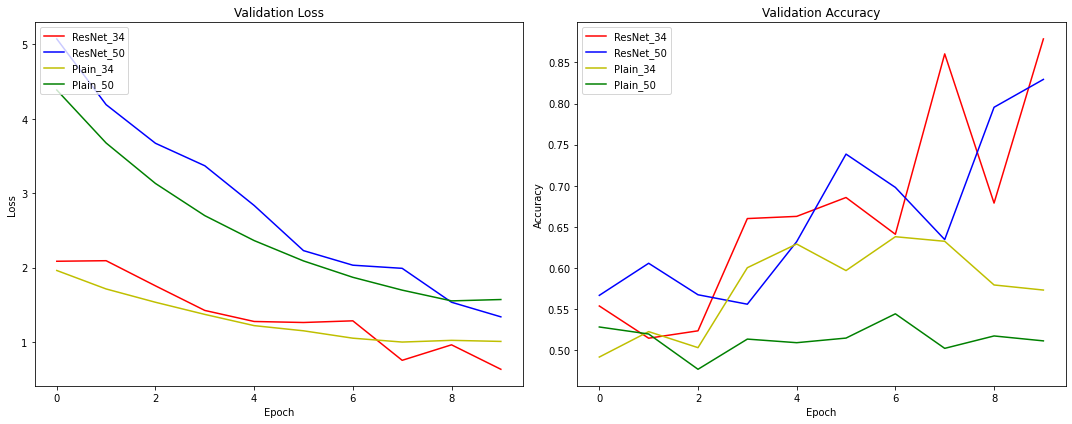

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_resnet_50.history['val_loss'], 'b')
plt.plot(history_plain_34.history['val_loss'], 'y')
plt.plot(history_plain_50.history['val_loss'], 'g')
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'y')
plt.plot(history_plain_50.history['val_accuracy'], 'g')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_All.png')

plt.show()

- 여기까지의 결과를 미루어 보아 가장 성능이 뛰어난 것은 ResNe 34 > ResNet 50 > Plain 34 > Plain 50 순이었다.

## ✔️회고 및 결론
---

#### ▶️ 이번 프로젝트에서 어려웠던 점

다른 분들 걸 참고해서 에폭 10정도로만 했는데도 시간이 어마어마하게 걸려서 당황했다. 그리고... Cat VS Dog데이터가 불러와지지 않았던 점에서도 시간을 많이 잡아먹었는데 다행히 해결 방법을 공유해주신 분들이 계셔서 살았다.

<br>

#### ▶️ 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

특히 Resnet의 경우 순차적인 시퀀셜 방식으로는 만들 수 없는 구조이기 때문에 모델을 구성할 때 함수적으로 쌓아올려나가야 한다는 점이 일반적인 plain에서의 차이인 것 같다. 이 방법에서 애를 먹어서 다른 데서 찾아봤었는데... VGG랑은 형태도 다르고 무엇보다 중간의 구조에 스킵하는 잔차가 따로 있어서 이걸 구현하는 방식을 찾는다는게 쉽진 않았던 기억이 난다.

<br>


#### ▶️ 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 프로젝트에서 루브릭의 기준은 아래와 같았다.

|       |                                    **< 평가문항 >**                                   |                                                              **< 상세기준 >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?                                 | 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.                                                        |
| **2** | 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?<br> | cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.                               |
| **3** | Ablation Study 결과가 바른 포맷으로 제출되었는가?                                    | ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다. |

처음 혼자 마구잡이로 만들때는 모델이 한번 꼬였던 모양인지 도통 학습이 안되서 애를 먹었는데... 그래도 다른 깃허브 코드들을 최대한 보고서 만들고 나니까 좀 에폭에 따라서 떨어지는 것이 보여서 다행이었다. 하지만 아직도 혼자서 잔차가 들어있는 모델을 온전히 다 만든다는건 여전히 쉽지 않은 문제 같다. 사실 Accuracy가 다른데서는 거의 80 ~ 90 에 육박하다가 여기는 많아봐야 70이 채 간당간당한 정도인걸로 봐서는 아직 갈길이 멀구나 싶었다.


<br>

#### ▶️ 자기 다짐

모델을 구현하기 위해서는... 이제는 논문을 좀 더 봐야겠다는 생각이 들었다. 확실히 예전 논문들이 왜 지금까지도 화자되는지, 이 모델들의 구조들이 왜 지금에서도 공부되는지에 대해서도 한번씩 돌아볼만한 계기였다.

<br>

## ✔️Reference(참고자료)
---
* https://oi.readthedocs.io/en/latest/computer_vision/cnn/resnet.html
* http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006
* https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py#L20
* https://git.dst.etit.tu-chemnitz.de/external/tf-models/-/blob/1d057dfc32f515a63ab1e23fd72052ab2a954952/official/vision/image_classification/resnet_model.py